In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [56]:
np.arange(0,10,0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

In [57]:
grid_points = [(x,y,spd*np.cos(theta),spd*np.sin(theta)) for x in np.arange(0,10,1.0) for y in np.arange(0,10,1.0) for theta in np.arange(0,2*np.pi,0.25*np.pi) for spd in np.arange(1,1.5,0.1)]

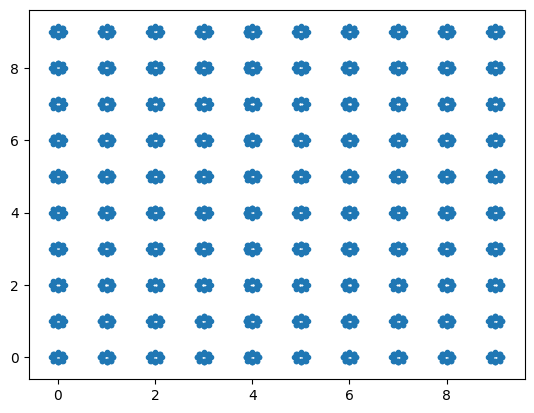

In [58]:
vel_scale = 0.1
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'.')

In [59]:
num_points = len(grid_points)
print(num_points)

4000


In [60]:
cost_matrix = np.inf*np.ones((num_points,num_points))

In [ ]:
dmax = 1.1
tmax = 2.0*dmax/1.0

def travel_time(s1,s2):
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    if x1==x2 and y1==y2:
        return np.inf
    if np.abs(x1-x2)>dmax:
        return np.inf
    if np.abs(y1-y2)>dmax:
        return np.inf
    if x1==x2:
        if vx1!=vx2:
            return np.inf
        ax = 0.0
    else:
        ax = 0.5*(vx2**2 - vx1**2)/(x2-x1)
    if ax==0.0:
        tx = (x2-x1)/vx1
    else:
        tx = (vx2-vx1)/ax
    if tx>tmax:
        return np.inf
    if tx<0:
        return np.inf
    if y1==y2:
        if vy1!=vy2:
            return np.inf
        ay = 0.0
    else:
        ay = 0.5*(vy2**2 - vy1**2)/(y2-y1)
    if ay==0.0:
        ty = (y2-y1)/vy1
    else:
        ty = (vy2-vy1)/ay
    if ty>tmax:
        return np.inf
    if ty<0:
        return np.inf
    t = max(tx,ty)
    print(t)
    return t
    

In [74]:
for (i1,s1) in enumerate(grid_points):
    for (i2,s2) in enumerate(grid_points):
        t12 = travel_time(s1,s2)
        cost_matrix[i1,i2] = t12

C:\Users\aeagr\AppData\Local\Temp\ipykernel_13092\3058084568.py:19: RuntimeWarning: invalid value encountered in double_scalars
  tx = (vx2-vx1)/ax
C:\Users\aeagr\AppData\Local\Temp\ipykernel_13092\3058084568.py:30: RuntimeWarning: invalid value encountered in double_scalars
  ty = (vy2-vy1)/ay
C:\Users\aeagr\AppData\Local\Temp\ipykernel_13092\3058084568.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  tx = (vx2-vx1)/ax


nan
nan
0.9523809523809523
0.9090909090909091
0.8695652173913043
0.8333333333333331
nan
0.9523809523809523
0.9090909090909091
0.8695652173913043
0.8333333333333331
2.175713172881684
2.0203050891044207
2.0
1.9999999999999998
1.9999999999999998
1.9999999999999998
1.9999999999999998
nan
0.9523809523809523
nan
0.8695652173913043
0.8333333333333334
0.7999999999999997
0.9523809523809523
nan
0.8695652173913043
0.8333333333333334
0.7999999999999997
2.175713172881684
2.0203050891044207
2.0
1.8181818181818181
1.8181818181818181
1.8181818181818181
1.8181818181818181
nan
0.9090909090909091
0.8695652173913043
nan
0.8
0.7692307692307689
0.9090909090909091
0.8695652173913043
nan
0.8
0.7692307692307689
2.175713172881684
2.0203050891044207
2.0
1.8181818181818181
1.6666666666666665
1.6666666666666665
1.6666666666666665
nan
0.8695652173913043
0.8333333333333334
0.8
nan
0.7407407407407401
0.8695652173913043
0.8333333333333334
0.8
nan
0.7407407407407401
2.175713172881684
2.0203050891044207
2.0
1.8181818181

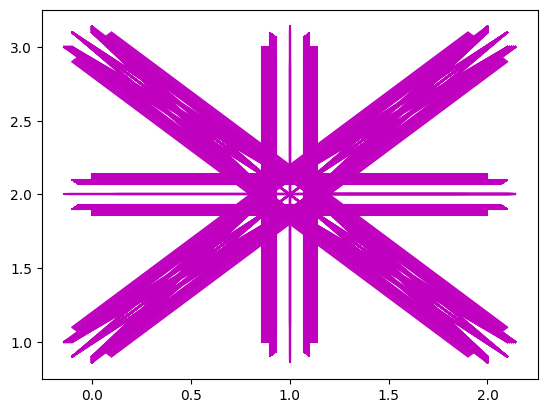

In [86]:
for (i1,s1) in enumerate(grid_points):
    if s1[0]!=1.0:
        continue
    if s1[1]!=2.0:
        continue
    for (i2,s2) in enumerate(grid_points):
        if cost_matrix[i1,i2] != np.inf:
            plt.plot([s1[0]+vel_scale*s1[2],s2[0]+vel_scale*s2[2]],
                     [s1[1]+vel_scale*s1[3],s2[1]+vel_scale*s2[3]],'m-')
plt.show()

In [76]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(cost_matrix, return_predecessors=True)

In [84]:
curr_node = 130
target_node = 220
print(grid_points[curr_node])
print(grid_points[target_node])
print(min(distance[curr_node,:]))
print(distance[curr_node,target_node])

(0.0, 3.0, 6.123233995736766e-17, 1.0)
(0.0, 5.0, -1.0, 1.2246467991473532e-16)
0.0
9.026455026455025


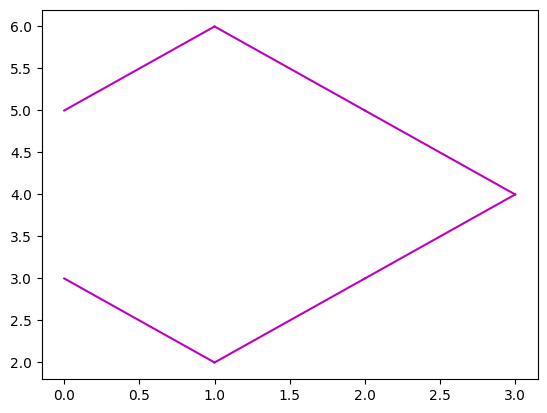

In [85]:
curr_node = 130
target_node = 210
for kk in range(len(grid_points)):
    next_node = predecessors[target_node,curr_node]
    plt.plot([grid_points[curr_node][0],
              grid_points[next_node][0]],
             [grid_points[curr_node][1],
              grid_points[next_node][1]],'m-')
    curr_node=next_node
    if curr_node==target_node:
        break
plt.show()